<a href="https://colab.research.google.com/github/Javier9898/Machine_Learning_Based_Playlist_Using_Personal_Spotify_Data/blob/master/Spotify_songs_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Building A Playlist Using Personal Spotify Data**

## **Introduction**
With the rising number of spotify users and the never ending amount of songs added each day, comes the increasing demand for efficiency and data driven decisions in satisfying the consumer musical needs. Instead of simply eyeballing music and gauging the surface level stats (duration, artists, listens, etc...), we can now look at an entire list of detailed stats that range from a songs speechiness which detects the presence of spoken words in a track, to simpler metrics of danceability. With these metrics, we can compare songs and determine which would be a good fit for a specific person based on their likings. In this project I use my own personal Spotify data gathered through the Privacy Settings of my Spotify account to accomplish just that.



## **Objectives**
In this project, different metrics will be utilized to determine the type of music that should be recommended to me based on song stats and trends that occur over time from my use of Spotify. In order to accomplish this, I will use stats of over 230,000 songs (gathered from a Kaggle dataset called "Spotify Tracks DB") and my own Spotify listening history dataset to explore the data.

## **Terms Used in the Dataset**
If you're intrested in learning about what the terms in each dataset mean you can visit:

https://support.spotify.com/uk/account_payment_help/privacy/understanding-my-data/ for a full explanation of the **personal Spotify dataset**.


https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/ for a full explanation of the **Spotify Tracks DB** dataset

## **Data files:**

1.   StreamingHistory0.json
2.   SpotifyFeatures.csv


## **Sources**

Spotify Tracks DB: https://www.kaggle.com/zaheenhamidani/ultimate-spotify-tracks-db

Spotify: https://www.spotify.com/pa/

Inspired by: "Así te manipulan para que te guste su música" https://www.youtube.com/watch?v=3ITv2yXteW4&list=FLgdGQ-vXSLlQPz5VWnBCL_A&index=2&t=0s



---



## **Code**

### Libraries

In [45]:
import numpy as np #  multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions
import pandas as pd # data manipulation

# data visualization libraries
import matplotlib.pyplot as plt  
import seaborn as sns 
import plotly.graph_objs as go
from plotly.offline import iplot

from zipfile import ZipFile # used in this project to unzip the data

# machine learning libraries
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics 
from sklearn.metrics import f1_score

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

### Unzipping Data

In [46]:
# Unzipping the data
def unzip(file_name):
  with ZipFile(file_name, 'r') as zip:
    zip.extractall()
    print("Done")


unzip("my_spotify_data.zip")
unzip("135088_566393_bundle_archive.zip")

Done
Done


In [47]:
StreamingHistory = pd.read_json('MyData/StreamingHistory0.json')
StreamingHistory.sample(3)

,endTime,artistName,trackName,msPlayed
6,2019-11-01 15:15,N.O.R.E.,Live My Life,53410
363,2020-06-06 17:15,Ricky Martin,Simple,215217
480,2020-06-15 01:16,SwuM,With U,218666


### Data Pre-processing

In [48]:
# Renaming columns for convenience
StreamingHistory = StreamingHistory.rename(columns={"endTime":"date","artistName":"artist","trackName":"track"})

I will define my favorite songs as a song with 3 or more listens. With this i can create a new dataframe that contains only those songs for a better handling of information. But **Why did i choose 3?**
As it can be seen from the histogram below, there's an exclusive amount of songs i've listened to more than twice. For me this is enough to tell a song is of my liking.

Text(0.5, 1.0, "Choosing which are my 'favorite' songs")

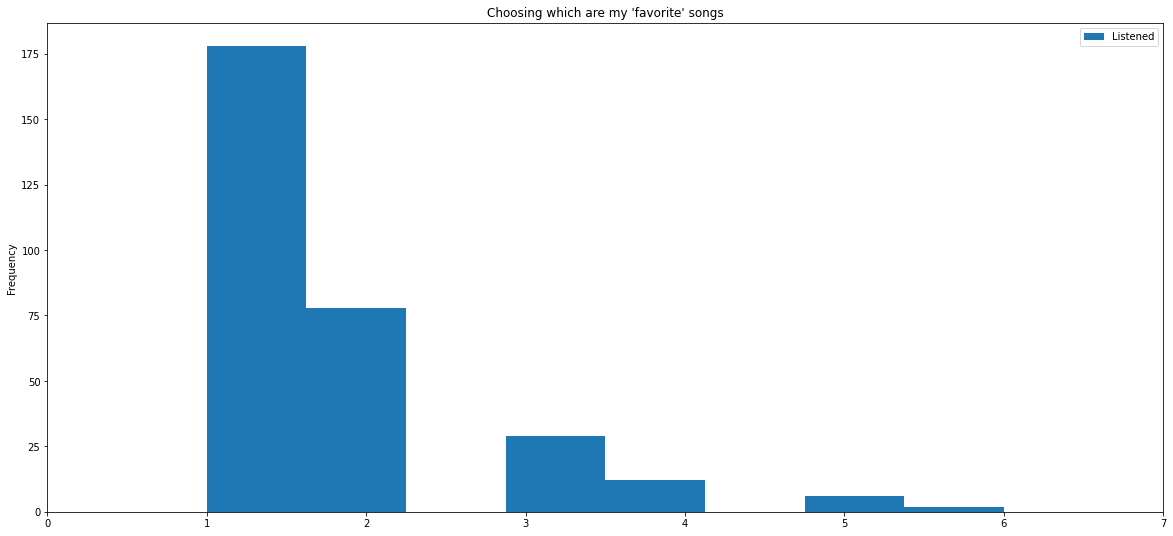

In [49]:
song_frequency = StreamingHistory.groupby(['artist','track']).size().to_frame('Listened').reset_index().plot(kind='hist',bins=8)
song_frequency.set_xlim(0,7)
song_frequency.set_title("Choosing which are my 'favorite' songs")

In [50]:
# Creating a Dataframes which keeps songs with 15 or more listens
favorite_songs = StreamingHistory.groupby(['artist','track']).size().to_frame('count').reset_index()
favorite_songs = favorite_songs[favorite_songs['count']>=3]

# Displaying the top 5 listened
favorite_songs.sort_values(by='count', ascending=False).head(5)

,artist,track,count
285,dj poolboi,we can be happy,6
283,dj poolboi,like we were the last two people on earth,6
90,Idealism,Lonely,5
141,Louie Zong,"Hello, World",5
284,dj poolboi,pretend we're okay,5


In [51]:
#Finding out how many songs are considered to be my favorites
favorite_songs.shape

(49, 3)

There are nearly 50 songs considered as "my favotires"

In [52]:
# Importing Spotify Features dataset
features = pd.read_csv("SpotifyFeatures.csv")
# renaming columns
features = features.rename(columns={"artist_name":"artist","track_name":"track"})
features.sample(3)

,genre,artist,track,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
80577,Opera,Richard Wagner,"Tannhauser, Act II: Einzug der Gaste auf der W...",6yQj9kWILfIsJJ8QDfIgfc,16,0.918000,0.275,398000,0.103,0.84500,B,0.0678,-19.624,Major,0.0373,129.928,4/4,0.161
136902,Reggae,Barrington Levy,Girl I Love You,6Sti1LHIG1UP1m6Bq1OUtR,30,0.000981,0.785,321527,0.426,0.10700,C#,0.1280,-13.971,Minor,0.0414,79.683,4/4,0.841
13111,Alternative,The Wonder Years,Pyramids of Salt,6mUSE1nLCzgt0ErxEIx1RM,42,0.001400,0.462,282080,0.763,0.00503,E,0.0847,-6.117,Major,0.0459,124.855,4/4,0.225


In [53]:
# Create a 'favorite' column (favorite = 1, not favorite = 0)
# This can be done by identifying the favorite songs within the list
features['same_artists'] = features.artist.isin(favorite_songs.artist) 
features['same_track'] = features.track.isin(favorite_songs.track) 
features["favorite"] = np.where((features["same_artists"] == True) & (features["same_track"] == True),1,0) # If both instances are True, fill the cell with 1, else place 0.
features = features.drop(["same_artists","same_track"],axis=1) # Dropping 'same_artist' and 'same_track'

features.sample(3)

,genre,artist,track,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,favorite
187075,Ska,Teenage Bottlerocket,Radio,5JeeIN2T3f5761d0hJmyzl,27,0.00569,0.460,143293,0.935,0.000175,G,0.291,-5.513,Major,0.0749,98.605,4/4,0.7560,0
167989,Comedy,Comedian Bob Marley,Itchy Boobs,7yoZBe2q8jE1jTisBirYnQ,34,0.85700,0.610,47360,0.432,0.000002,D,0.981,-16.001,Major,0.9260,97.475,4/4,0.8800,0
174512,Comedy,Eddie Izzard,Achilles Footwear,5YEj8ptQ9mmiq9UgDzgazz,13,0.79200,0.521,258867,0.858,0.000000,G,0.857,-16.595,Major,0.9060,121.431,4/4,0.0694,0


In [54]:
song_features = features.copy(deep=True)

In [55]:
features.loc[features['favorite'] == 1].shape

(16, 19)

There seems to only be data for 16 out of the 49 songs in my favorite songs list

Being the case that all track_ids are unique and are used to represent both the artist and song name, this feature will not be useful to predict a favorite song. It'll be useful to drop this feature. A similar problem can be found in the 'track' column. Its uniqueness, makes it have a very low correlation between 'track' and 'favorite'. I will also drop this column.

In [56]:
# Dropping 'track_id' from the features column
features = features.drop(columns='track_id')
features = features.drop(columns='track')

print("Done")

Done


### Balancing classes with SMOTE and Feature Selection

As my classes are overwhelmingly imbalanced, this will most likely make my model predict most songs as the majority class(not favorite, in my case). SMOTE creates machine learning based oversampling which for this case it'll create duplicate records fairly similar to one another allowing to add more samples to the minority class.

While I could undersample from the majority class, it'll result in losing big amounts of data given the margin as to how much the majority class surpasses the minority.

In [57]:
# Showing imbalances
features.favorite.value_counts()

0    232709
1        16
Name: favorite, dtype: int64

In [58]:
# Applying SMOTE
X = features.drop(columns=['favorite','genre','artist','key','mode','time_signature']) # Using only numerical values
y = features.favorite
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

columns = ['popularity', 'acousticness', 'danceability', 'duration_ms', 
             'energy','instrumentalness', 'liveness', 'loudness', 
             'speechiness', 'tempo','valence']

X = pd.DataFrame(data=X, columns=columns) 

X['favorite'] = y

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



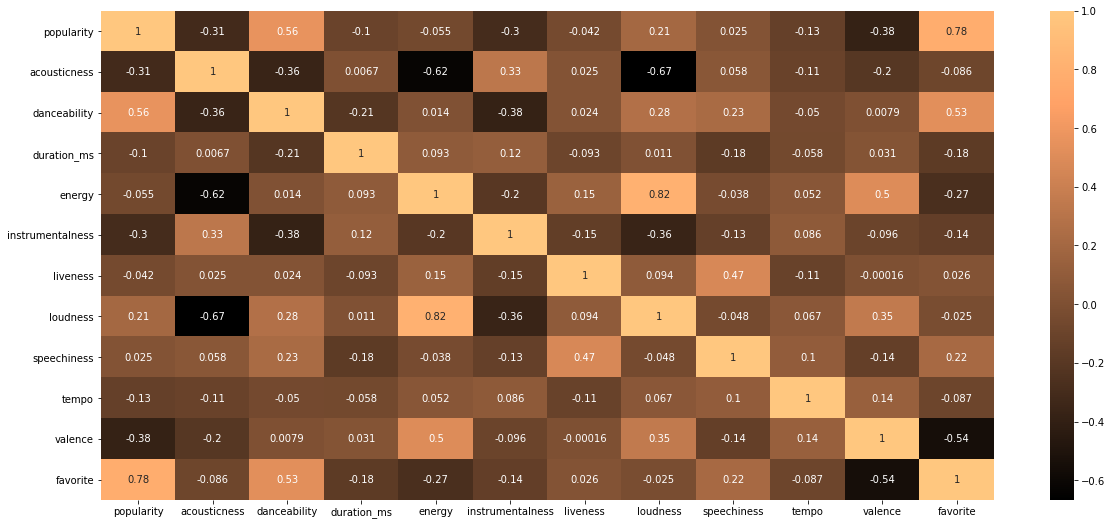

In [59]:
# Correlations Between the Data
plt.rcParams['figure.figsize'] = (20, 9)
sns.heatmap(X.corr(), cmap = 'copper', annot = True)

plt.show()

Of all the features, **popularity, danceability, and speechiness** have the highest associations to a song becoming a favorite. 

### Model Selection

In order to choose a good classifier for my recommender, I will compare two algorithms I consider to be great for the taks: **Decision Tree Classifier** and **Random Forest Classifier**. From this test i'll select the highest scored model.

To score these models i'll use the **F1-score** since its best used when False Negatives and False Positives are crucial and is a better metric when there are imbalanced classes as in the present case.

In [60]:
# Train / Split Data
X_train, X_test, y_train, y_test = train_test_split(X.drop(columns='favorite'), X.favorite,test_size = .25)

In [61]:
# Hyperparameter tuning for the DecisionTreeClassifier
parameters = {
    'max_depth':[15,20,30],
}
dtc = Pipeline([('CV', GridSearchCV(DecisionTreeClassifier(), parameters, cv = 5))])
dtc.fit(X_train, y_train)
dtc.named_steps['CV'].best_params_

{'max_depth': 30}

In [62]:
dt = DecisionTreeClassifier(max_depth=30)
dt_scores = cross_val_score(dt, X_train, y_train, cv=10, scoring="f1")
np.mean(dt_scores)

0.9998624686160802

In [63]:
# Hyperparameter tuning for the RandomForestClassifier
parameters = {
    'max_depth':[6,12,15,20],
    'n_estimators':[20,30]
}
clf = Pipeline([('CV', GridSearchCV(RandomForestClassifier(), parameters, cv = 5))])
clf.fit(X_train, y_train)
clf.named_steps['CV'].best_params_

{'max_depth': 20, 'n_estimators': 20}

In [64]:
# Cross-validation for RandomForestClassifier
rf = Pipeline([('rf', RandomForestClassifier(n_estimators = 20, max_depth = 30))])
rf_scores = cross_val_score(rf, X_train, y_train, cv=10, scoring="f1")
np.mean(rf_scores)

0.9999828062164813

Based on the score obtained, the Random Forest Tree is the best model to make predictions in this case.

Now, I will predict 'favorite' songs from the entire dataset.

### Predicting Songs

In [65]:
prediction = clf.predict(song_features.drop(columns=['track','track_id','favorite',
                                                     'genre','artist','key',
                                                    'time_signature','mode']))

In [66]:
# Adding a column for predictions
song_features['prediction'] = prediction

# With the recently created 'prediction' column we can get the songs that are not favorites but are predicted to be
song_recommendation = song_features[(song_features['favorite']==0) & (song_features['prediction'] == 1)]

In [67]:
# Cleaning the data so it only shows the necessary information 
song_recommendation = song_recommendation.drop(columns=['track_id','energy',
                                                        'duration_ms','acousticness','key',
                                                        'liveness','loudness','mode','speechiness',
                                                        'tempo','time_signature','valence'])

In [68]:
song_recommendation.sample(5)

,genre,artist,track,popularity,danceability,instrumentalness,favorite,prediction
109210,Pop,Young Thug,High (feat. Elton John),73,0.759,0.000058,0,1
87304,Rap,Rob $tone,Chill Bill,79,0.886,0.000990,0,1
87762,Rap,Shoreline Mafia,Whuss The Deal,71,0.837,0.000511,0,1
14054,Dance,Camila Cabello,OMG,72,0.655,0.115000,0,1
138923,Reggaeton,Bad Bunny,Caro,85,0.651,0.000202,0,1


In [69]:
# Consulting how many songs were predicted as favorites
song_recommendation.shape

(119, 8)

These is the resulting product of my song recommender, a good amount of songs out of the 232725 available from the "Spotify Tracks DB" were predicted to become my favorites. From the results I've gotten, I can confirm that i do know some of these artists and enjoy listening to their music.

### Saving the results

In [70]:
song_recommendation.to_csv("recommendations.csv")
print("Done")

Done
